# Интеллектуальный анализ данных – весна 2025
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.
* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [99]:
import warnings

import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

warnings.filterwarnings("ignore")

In [100]:
df = pd.read_csv('./tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
796,4755,49707,NaN,17-03-2020,@DuScarla @wanda1606 @CarolineVoaden @Emmanuel...,Negative
9108,14855,59807,India,20-03-2020,Breaking Union Minister of Consumer Affairs Fo...,Positive
16738,24179,69131,Michigan,25-03-2020,Nice job Stop amp Shop northeastern grocery st...,Extremely Negative
3165,7631,52583,Al Hilal - C Ring Road,18-03-2020,"#MoCI sets prices for hand #sanitisers, #disin...",Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная или очень положительная эмоциональная окраска и 0 - если отрицательная или очень отрицательная.

In [101]:
# было
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,Positive


In [102]:
df["Sentiment"] = np.where(df["Sentiment"].str.contains("[Pp]ositive"), 1, 0)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1


Сбалансированы ли классы?

In [103]:
sentiment_vc = df["Sentiment"].value_counts()
sentiment_vc

Sentiment
1    18046
0    15398
Name: count, dtype: int64

In [104]:
dif = np.abs(sentiment_vc.iloc[0] - sentiment_vc.iloc[1]) / np.max([sentiment_vc.iloc[0], sentiment_vc.iloc[1]])
np.round(100 * dif, 2)

14.67

**Ответ:** разница в $\thicksim$15% приемлема для принятия отношения
классов за сбалансированные

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [105]:
df.isna().sum()

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

Нет данных про локацию, заменим все пустой строкой `unknown`

In [106]:
df["Location"] = df["Location"].fillna("unknown")
df.isna().sum()

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и укажите `random_state=0`

In [107]:
from sklearn.model_selection import train_test_split

y = df["Sentiment"]
X = df.drop(["Sentiment"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр.

In [108]:
words_data = {}

def add_to_words(text_sample):
    words = map(lambda x: x.lower(), text_sample.split())
    for w in words:
        words_data[w] = words_data.get(w, 0) + 1
        
X_train["OriginalTweet"].apply(add_to_words)

30027    None
28206    None
8905     None
11897    None
11873    None
         ... 
5238     None
3342     None
5074     None
10512    None
19960    None
Name: OriginalTweet, Length: 23410, dtype: object

Какой размер словаря получился?

In [109]:
len(words_data)

79735

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе.

In [110]:
words_data_s = pd.Series(words_data)
words_data_s = words_data_s.sort_values(ascending=False)
words_data_s.head(10)

the             26682
to              23383
and             14683
of              12857
a               11697
in              11210
for              8519
#coronavirus     8243
is               7373
are              7016
dtype: int64

**Ответ:** Стоп-слова. Стоит заметить, что эти слова не склоняются, и потому их может 
быть больше, чем, например, склоняемых слов.

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [111]:
import nltk
from nltk.corpus import stopwords

st_w = stopwords.words("english")

new_index_bool = ~np.in1d(words_data_s.index, st_w)
new_index = words_data_s.index[new_index_bool]

words_data_no_stopwords = words_data_s.reindex(new_index)

words_data_no_stopwords.head(10)

#coronavirus    8243
prices          3838
food            3827
grocery         3397
supermarket     3325
store           3158
people          3120
covid-19        3069
#covid19        2507
consumer        2247
dtype: int64

**Ответ:** кроме, собственно, ковида, обсуждается функционирование магазинов 
и цен: сама основа быта каждого человека. Очевидный вывод: ковид консулся человека настолько плотно, что основные темы для обсуждения - самые низовые потребности, такие как купить покушать.

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше, выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [112]:
words_data_no_stopwords.tail(20)

https://t.co/f8jjwc6mvb    1
https://t.co/x3qrxixl17    1
ãâplease                 1
kindãâ                   1
received!                  1
shop-lifting               1
https://t.co/k0kgjgjjxu    1
1-metre                    1
ontarians:                 1
??can't                    1
??impacted                 1
??must                     1
yogurt                     1
#ontariodairyboard         1
https://t.co/ar5uwvvojy    1
patrickcobb                1
patrick,                   1
distancingãâ             1
https://t.co/8eamxvsghm    1
feared,                    1
dtype: int64

**Ответ:** работать с этими токенами не получится, но это не говорит, что, например, 
токен `prohibitions` (который в топ-20 самых редких) ни о чем не может нам сказать. Просто обработка текста путем сплита по пробелам может дать очень грубые усреднения, на которые можно ориентироваться, только когда ничего другого нет. Этим и займемся..



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [113]:
from nltk.tokenize import TweetTokenizer
from string import punctuation

tokens = {}
tokenizer = TweetTokenizer()

st_l = st_w + list(punctuation)

def parse_tokens(text_sample):
    ts = tokenizer.tokenize(text_sample)
    for t in ts:
        t = t.lower().strip()
        if len(t) == 1 and ord(t) >= 128:
            continue
        if t not in st_l:
            tokens[t] = tokens.get(t, 0) + 1

X_train["OriginalTweet"].apply(parse_tokens)

tokens = pd.Series(tokens).sort_values(ascending=False)
tokens.head(10)

#coronavirus    8819
19              7003
covid           6087
prices          4564
food            4378
store           3868
supermarket     3858
grocery         3451
people          3422
#covid19        2622
dtype: int64

**Ответ:** в целом, усреднение по сплиту оказалось полезнее, чем можно было предположить.
Топ значений сохранился, как и интерпретация всего этого дела.

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [114]:
from string import punctuation

# -- YOUR CODE HERE --

**Ответ:** упс, уже сделал

Скорее всего в некоторых топах были неотображаемые символы или отдельные буквы не латинского алфавита. Уберем их: удалите из словаря токены из одного символа, позиция которого в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [115]:
tokens.tail(20)

vix                        1
shootout                   1
https://t.co/dufpsf9hxa    1
vigilance                  1
https://t.co/aq8wnws32l    1
@austen                    1
https://t.co/xhxtz63vi3    1
sudbury                    1
@apickrellctv              1
https://t.co/arv57dzgns    1
https://t.co/buo2a3pald    1
brightram                  1
@qz                        1
rejoin                     1
@markneary18               1
precludes                  1
https://t.co/is6phumisa    1
https://t.co/zf0x7ccmzz    1
https://t.co/stswfpcjwy    1
facade                     1
dtype: int64

**Ответ:**

Изначально я захардкодил пару неинформативных символов, добавив в стоп-лист, но увидев этот пункт изменил решение.

Говоря о репрезентативности: топ остался тот же (или почти тот же, но новых выводов сделать нельзя), однако хвост оказался более репрезентативен. Несмотря на теги, ссылки и прочий смысловой мусор, о каких-то токенах мы можем рассуждать как о непопулярных, например, `wrinkles`, `ombudsman` 

Выведите топ-10 популярных хештегов (токены, первые символы которых - #) с количеством встреч. Что можно сказать о них?

In [116]:
hashtag_pattern = r'^#.+'

hashtags_bool = tokens.index.str.match(hashtag_pattern)
hashtags_index = tokens.index[hashtags_bool]

hashtags = tokens.reindex(hashtags_index)
hashtags.head(20)

#coronavirus            8819
#covid19                2622
#covid_19               1790
#covid2019               971
#toiletpaper             728
#covid                   641
#socialdistancing        492
#coronacrisis            437
#pandemic                259
#coronaviruspandemic     257
#stayhome                228
#coronavirusoutbreak     224
#covid-19                218
#stayathome              215
#lockdown                215
#corona                  212
#stayhomesavelives       205
#supermarket             200
#retail                  191
#panicbuying             188
dtype: int64

**Ответ:** 

Выводы похожи на вывод для всех токенов, но с оговоркой. Кроме упоминаний базоых нужд, таких как туалетная бумага и магазины, можно заметить, что хештеги подсвечивают посыл, идею и внутренную ценность автора. Например, `stayhome`, `stayhomesavelives`, `socialdistancing` - явные призывы к действую. Возможно, имеет смысл удеелить хештегам больше внимания при обучении модели.

*выбрал топ-20 для большей репрезентативности*

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [117]:
url_pattern = r'^https://t\.co'

url_bool = tokens.index.str.match(url_pattern)
url_index = tokens.index[url_bool]

links = tokens.reindex(url_index)
links.head(20)

https://t.co/oxa7swtond    4
https://t.co/r7sagojsjg    4
https://t.co/ymsemlvttd    3
https://t.co/3kfuiojxep    3
https://t.co/gu6b4xpqp4    3
https://t.co/gp3eusapl8    3
https://t.co/pe99mhrsat    3
https://t.co/mlw1gfkzna    3
https://t.co/catkegayoy    3
https://t.co/e2znxajpre    3
https://t.co/wrlhyzizaa    3
https://t.co/hpo7uwkakl    3
https://t.co/jpgmr5hcsc    3
https://t.co/7txojqdl04    3
https://t.co/g63rp042ho    3
https://t.co/6yvykiab2c    3
https://t.co/xpcm2xkj4o    3
https://t.co/3gbbdpdjat    3
https://t.co/2ulz8jrfqw    2
https://t.co/pj4ricpwya    2
dtype: int64

**Ответ:** самая популярная ссылка имеет 5 твитов с ней, что очень мало. Так что нет, ссылки
для анализа не принесут ничего полезного, так как малое количесво данных не может позволить сделать какие-то знаяимые связи.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для  выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа с позицией в таблице Unicode 128 и более,  ссылки на t.co



In [118]:
# не думал не гадал, но уже почти написал его выше

from nltk.tokenize import TweetTokenizer
from string import punctuation
import re

tokenizer = TweetTokenizer()

st_l = st_w + list(punctuation)

def custom_tokenizer(text):
    tokens = []
    ts = tokenizer.tokenize(text)
    
    for t in ts:
        t = t.lower().strip()
        
        if len(t) == 1 and ord(t) >= 128:
            continue
        if len(re.findall(url_pattern, t)) > 0:
            continue
        if t in st_l:
            continue

        tokens.append(t)

    return tokens


In [119]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [120]:
X_train.shape

(23410, 5)

In [121]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
cv.fit_transform(X_train["OriginalTweet"])

print(len(cv.vocabulary_))

45315


**Ответ:** # -- YOUR ANSWER HERE --

было: 45308

Посмотрим на какой-нибудь конкретный твитт:

In [122]:
ind = 9023
df.iloc[ind]['OriginalTweet'], df.iloc[ind]['Sentiment']

("Shop keepers taking advantage of #Coronavirus boosting prices disproportionately so the most Marginalised suffer who can't afford it #SHAMEONYOU #Wewillremember",
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [123]:
arr = cv.transform([df.iloc[ind]['OriginalTweet']]).toarray()
bof = pd.Series(arr.reshape(-1), index=cv.get_feature_names_out())
bof = bof.sort_values(ascending=False)
bof.head(20)

#shameonyou           1
shop                  1
advantage             1
#coronavirus          1
taking                1
disproportionately    1
suffer                1
can't                 1
keepers               1
prices                1
marginalised          1
#wewillremember       1
afford                1
boosting              1
interrupted           0
interruptions         0
interrupters          0
interruption          0
###covid-19           0
intersection          0
dtype: int64

**Ответ:** самых важных слово в тексте - 11, ровно столько в нем токенов.
То есть каждое слово имеет одинаковый вес в данном представлении. То есть мы не смогли отпределить самого важногог токена.

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [124]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(tokenizer=custom_tokenizer)
tfidf_vec.fit(X_train["OriginalTweet"])

ans = tfidf_vec.transform([df.iloc[ind]['OriginalTweet']]).toarray()

needed_indexes = custom_tokenizer(df.iloc[ind]['OriginalTweet'])

sample_v = pd.Series(ans.reshape(-1), index=tfidf_vec.get_feature_names_out())
sample_v = sample_v.reindex(needed_indexes)
sample_v = sample_v.sort_values(ascending=False)
sample_v.head(20)

marginalised          0.372229
#wewillremember       0.372229
#shameonyou           0.357672
disproportionately    0.332786
keepers               0.322457
boosting              0.305027
suffer                0.273826
afford                0.226760
advantage             0.210476
can't                 0.195721
taking                0.185294
shop                  0.171499
prices                0.096851
#coronavirus          0.071150
dtype: float64

**Ответ:**

Маргинализировать в самом деле обычно имеет негативную окраску как что-то непопулярное и отталкивающие массы. Так что браво! Да и весь топ-3 (который очень похож по важности) сильно передает негативную окраску текстов. 

И последнему месту браво не меньше, ведь коронавирус упоминаются в таком большом количестве твитов, что на этот токен не имеет смысла ориентироваться.

-------------

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [125]:
idx = 33169

# в предложении есть слово "hope"
sample = df.iloc[idx]
sample["OriginalTweet"]

"On the way home, I wanted to stop by a grocery store for a few items but I didn't. It can wait. I hope my decision today saved a life or two! #DidntDoList #StayHomeSaveLives"

In [126]:
needed_indexes = custom_tokenizer(df.iloc[idx]['OriginalTweet'])

ans = tfidf_vec.transform([df.iloc[idx]['OriginalTweet']]).toarray()

sample_v = pd.Series(ans.reshape(-1), index=tfidf_vec.get_feature_names_out())
sample_v = sample_v.reindex(needed_indexes)
sample_v = sample_v.sort_values(ascending=False)
sample_v.head(20)

#didntdolist          0.444726
saved                 0.341868
decision              0.306653
wanted                0.289260
wait                  0.266668
#stayhomesavelives    0.245920
hope                  0.233062
life                  0.232755
two                   0.223306
items                 0.207798
way                   0.205628
stop                  0.191945
today                 0.189251
home                  0.168751
grocery               0.126756
store                 0.122579
dtype: float64

**Ответ:** Сравнивая мое предположительный токен: `hope`, и токен, выделенный
алгоритмом, я склоняюсь к его версии! `saved` сразу навеевает позитив на сообщение. А что значит `#didntdolist` я так и не понял 

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [127]:
simple_cv_train = cv.transform(X_train['OriginalTweet'])
tfidf_vc_train = tfidf_vec.transform(X_train['OriginalTweet'])

simple_cv_test = cv.transform(X_test['OriginalTweet'])
tfidf_vc_test = tfidf_vec.transform(X_test['OriginalTweet'])

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

Используйте `sparse` матрицы (после векторизации), не превращайте их в `numpy.ndarray` или `pd.DataFrame` - может не хватить памяти.

In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_simple = LogisticRegression()
lr_tfidf = LogisticRegression()

lr_simple.fit(simple_cv_train, y_train)
lr_tfidf.fit(tfidf_vc_train, y_train)

simple_cv_train_pred = lr_simple.predict(simple_cv_train)
tfidf_cv_train_pred = lr_tfidf.predict(tfidf_vc_train)

simple_cv_test_pred = lr_simple.predict(simple_cv_test)
tfidf_cv_test_pred = lr_tfidf.predict(tfidf_vc_test)

data_accuracy = {
    "count_train": accuracy_score(simple_cv_train_pred, y_train),
    "count_test": accuracy_score(simple_cv_test_pred, y_test),
    "tfidf_train": accuracy_score(tfidf_cv_train_pred, y_train),
    "tfidf_test": accuracy_score(tfidf_cv_test_pred, y_test),
}

pd.Series(data_accuracy)

count_train    0.984195
count_test     0.870540
tfidf_train    0.924306
tfidf_test     0.850807
dtype: float64

**Ответ:** на наших моделях себя лучше показал логистический регрессор,
и на `test`, и на `train` выборках. Получается, на данном примере себя намного лучше показал вариант векторизации попроще. Интерпретирвоать это сложно, на самом деле, но поптаюсь:

ладно, я не знаю, сдаюсь...

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [129]:
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import SnowballStemmer
from string import punctuation
import re

tokenizer = TweetTokenizer()
stemmer = SnowballStemmer("english")
st_l = st_w + list(punctuation)

def custom_stem_tokenizer(text):
    tokens = []
    ts = tokenizer.tokenize(text)
    ts = [stemmer.stem(t) for t in ts]
    
    for t in ts:
        t = t.lower().strip()
        
        if len(t) == 1 and ord(t) >= 128:
            continue
        if len(re.findall(url_pattern, t)) > 0:
            continue
        if t in st_l:
            continue

        tokens.append(t)

    return tokens

In [130]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [131]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
cv.fit(X_train["OriginalTweet"])

print(len(cv.vocabulary_))

36662


**Ответ** Что предсказуемо, словарных запас значительно сохранился, ведь 
функция стемминга от невозрастающая (слов станосится меньше или равно). А так как наш корпус текстов был велик, он уменьшился.

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [132]:
count_vc_stemed = CountVectorizer(tokenizer=custom_stem_tokenizer)
tfidf_vc_stemed = TfidfVectorizer(tokenizer=custom_stem_tokenizer)

count_vc_stemed.fit(X_train["OriginalTweet"])
tfidf_vc_stemed.fit(X_train["OriginalTweet"])

count_vc_test = count_vc_stemed.transform(X_test["OriginalTweet"])
count_vc_train = count_vc_stemed.transform(X_train["OriginalTweet"])

tfidf_vc_test = tfidf_vc_stemed.transform(X_test["OriginalTweet"])
tfidf_vc_train = tfidf_vc_stemed.transform(X_train["OriginalTweet"])

In [133]:
lr_count = LogisticRegression()
lr_tfidf = LogisticRegression()

lr_count.fit(count_vc_train, y_train)
lr_tfidf.fit(tfidf_vc_train, y_train)

count_train_pred = lr_count.predict(count_vc_train)
tfidf_train_pred = lr_tfidf.predict(tfidf_vc_train)

count_test_pred = lr_count.predict(count_vc_test)
tfidf_test_pred = lr_tfidf.predict(tfidf_vc_test)

data_stem_accuracy = {
    "count_train": accuracy_score(count_train_pred, y_train),
    "count_test": accuracy_score(count_test_pred, y_test),
    "tfidf_train": accuracy_score(tfidf_train_pred, y_train),
    "tfidf_test": accuracy_score(tfidf_test_pred, y_test),
}

pd.Series(data_stem_accuracy)


count_train    0.971038
count_test     0.868846
tfidf_train    0.916104
tfidf_test     0.855990
dtype: float64

**Ответ:** применив стеминг значения при `CountVectorizer` почти не изменились
(что даже похоже на ошибку, но вроде нет), и `TfidfVectirizer` изменился несущественно: минус процент на обучающей, плюс процент на тестовой. В данно мпримере нет смсла использовать стемминг. Качество моделей меняется несущественно.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [146]:
possible = np.linspace(0.1, 1, 5)
for p in possible:
    cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=p
                        ).fit(
                            X_train["OriginalTweet"]
                            )
    print(len(cv_df.vocabulary_), p)

36650 0.1
36661 0.325
36662 0.55
36662 0.775
36662 1.0


**Ответ:** получается, только 2 слова встречались в более чем 10% текстов,
и только одно в более чем  в 32.5% текстов. Значение в ответ - 0.325, так как оно вычеркивает одно значение из текста.

Это можно интерпретировать так: люди редко используют одни и те же слова (токены) (не считая мусорные stop-words), когда пишут посты.

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [161]:
def din_search(l, r, res):
    eps = 1e-10
    while (r - l) > eps:
        mid = (l + r) / 2
        
        cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=mid
                        ).fit(
                            X_train["OriginalTweet"]
                            )
        cur_amount = len(cv_df.vocabulary_)

        print(cur_amount, l, r)

        if cur_amount < res: # то есть слов у нас мало, надо больше слов! надо уменьшить границу
            r = mid
        elif cur_amount == 3700:
            return mid
        else:
            l = mid
        
    return l

In [162]:
din_search(0.0001, 0.1, 3700)

36 0.0001 0.1
104 0.0001 0.050050000000000004
244 0.0001 0.025075000000000004
523 0.0001 0.012587500000000001
974 0.0001 0.00634375
1620 0.0001 0.0032218750000000003
2436 0.0001 0.0016609375
3513 0.0001 0.0008804687500000001
5006 0.0001 0.000490234375
3933 0.0002951171875 0.000490234375
3698 0.00039267578125 0.000490234375
3933 0.00039267578125 0.000441455078125
3698 0.0004170654296875 0.000441455078125
3933 0.0004170654296875 0.00042926025390624997
3933 0.000423162841796875 0.00042926025390624997
3698 0.00042621154785156247 0.00042926025390624997
3933 0.00042621154785156247 0.00042773590087890625
3698 0.00042697372436523433 0.00042773590087890625
3933 0.00042697372436523433 0.0004273548126220703
3698 0.0004271642684936523 0.0004273548126220703
3698 0.0004271642684936523 0.0004272595405578613
3698 0.0004271642684936523 0.0004272119045257568
3698 0.0004271642684936523 0.00042718808650970457
3698 0.0004271642684936523 0.0004271761775016784
3933 0.0004271642684936523 0.0004271702229976653

KeyboardInterrupt: 

**Ответ:** получатся, четку грань найти сложно, однако число 
`0.0004271679900586605` наиболее подходит под условие задачи.

Интерпретация: всего доли процента достаточно, чтобы отрезать большую часть слов (токенов). То есть слова редко встрнечаются в разных текстах.

In [221]:
min_db_var = 0.0004271679900586605

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `barplot`, содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [170]:
from sklearn.preprocessing import StandardScaler

count_vc_data = CountVectorizer(
    tokenizer=custom_stem_tokenizer,
    min_df=min_db_var
)

train = count_vc_data.fit_transform(X_train["OriginalTweet"])
test = count_vc_data.transform(X_test["OriginalTweet"])

sc = StandardScaler(with_mean=False)
sc.fit(train)
train_normed = sc.transform(train)
test_normed = sc.transform(test)

lr = LogisticRegression()
lr.fit(train_normed, y_train)

train_pred = lr.predict(train_normed)
test_pred = lr.predict(test_normed)

accuracy = {
    "train": accuracy_score(train_pred, y_train),
    "test": accuracy_score(test_pred, y_test)
}

data_ans = pd.Series(accuracy)
data_ans

train    0.942161
test     0.835758
dtype: float64

In [186]:
tokens_weigth = pd.Series(
    data=lr.coef_[0],
    index=count_vc_data.get_feature_names_out()
)
tokens_weigth = tokens_weigth.sort_values()
tokens_weigth

crisi   -1.803679
panic   -1.358317
scam    -1.157640
kill    -0.712733
war     -0.650703
           ...   
best     0.936242
thank    0.965898
free     0.986654
help     1.103822
hand     1.133040
Length: 3698, dtype: float64

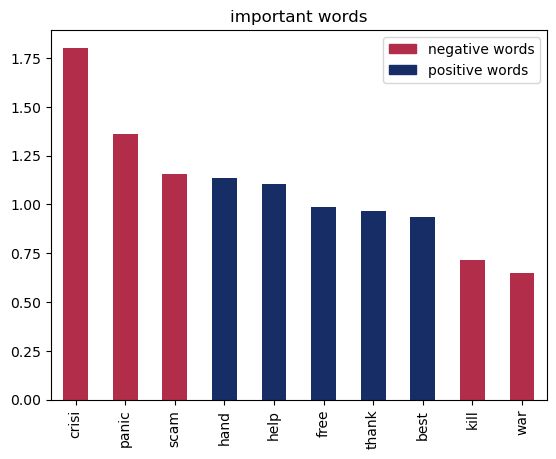

In [220]:
import matplotlib.patches as mpatches

positive = tokens_weigth[tokens_weigth > 0]
negative = tokens_weigth[tokens_weigth < 0]

top_5_positive = positive.iloc[-5:]
top_5_negative = negative.iloc[:5]

top_score = pd.DataFrame(
    data=pd.concat([top_5_positive, top_5_negative]),
    columns=["coef"]
)

top_score["is_positive"] = top_score["coef"] > 0
top_score["coef"] = top_score["coef"].abs()
top_score = top_score.sort_values("coef", ascending=False)

blue_c = "#162E65"
red_c = "#B12D49"
color_bar = np.where(top_score["is_positive"], blue_c, red_c)

red_patch = mpatches.Patch(color=red_c, label='negative words')
blue_patch = mpatches.Patch(color=blue_c, label='positive words')

ax = top_score.plot.bar(y="coef", color=color_bar, title="important words")
ax.legend(handles=[red_patch, blue_patch])

**Ответ:** Данные токены самые важные в процессе анализа и определения
тональности текста. Все они в самом деле (по субъективному мнению) отображают позитивную или негативную окраску.

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [ ]:
# -- YOUR CODE HERE --

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

In [ ]:
# -- YOUR CODE HERE --

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [ ]:
# -- YOUR CODE HERE --

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [ ]:
# -- YOUR CODE HERE --

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [ ]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --